In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
import time
%matplotlib inline

# 1. Загрузка данных

In [2]:
(train_dataset), (test_dataset) = mnist.load_data()

In [3]:
def show_images_keras(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i]
        ax.imshow(img, cmap = 'gray')

Визуально отобразим несколько примеров из тренировочной и тестовой выборки.

Number of train samples: 60000
Number of test samples: 10000


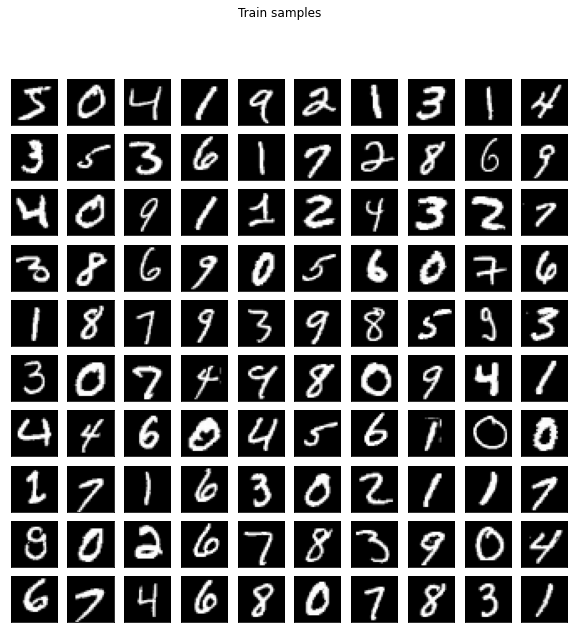

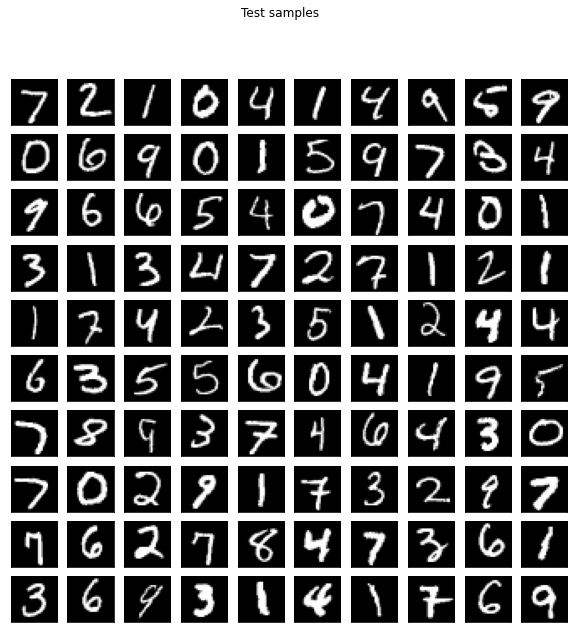

In [4]:
print('Number of train samples: {}'.format(len(train_dataset[0])))
show_images_keras(train_dataset[0], 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset[0])))
show_images_keras(test_dataset[0], 'Test samples')

In [5]:
print('Размерность входных данных тренировочной выборки: {}'.format(train_dataset[0].shape))
print('Размерность входных данных тестовой выборки: {}'.format(test_dataset[0].shape))
print()
print('Размерность ответов тренировочной выборки: {}'.format(train_dataset[1].shape))
print('Размерность ответов тестовой выборки: {}'.format(test_dataset[1].shape))
print()
print('Тип входных данных {}'.format(train_dataset[0].dtype))

Размерность входных данных тренировочной выборки: (60000, 28, 28)
Размерность входных данных тестовой выборки: (10000, 28, 28)

Размерность ответов тренировочной выборки: (60000,)
Размерность ответов тестовой выборки: (10000,)

Тип входных данных uint8


Преобразуем каждый объект входных данных к новой размерности (вместо матрицы вектор). Затем приведем к вещественному типу. Поделим на 255, чтобы значения лежали в диапозоне от 0 до 1. 

Для каждого объекта ответ представим как вектор размерности равной числу классов, состояющий из нулей за исключением $i$-ой компоненты, соответсвующей номеру класса.

In [6]:
w = train_dataset[0].shape[1]
h = train_dataset[0].shape[2]
classes = 10

# смена размерности
train_X = train_dataset[0].reshape(train_dataset[0].shape[0], w * h)
test_X = test_dataset[0].reshape(test_dataset[0].shape[0], w * h)

# преобразование типа
train_X = train_X.astype('float32') / 255
test_X = test_X.astype('float32') / 255

# преобразование ответов
train_y = np.eye(classes)[train_dataset[1]]
test_y = np.eye(classes)[test_dataset[1]]

In [7]:
print('Размерность входных данных тренировочной выборки: {}'.format(train_X.shape))
print('Размерность входных данных тестовой выборки: {}'.format(test_X.shape))
print()
print('Размерность ответов тренировочной выборки: {}'.format(train_y.shape))
print('Размерность ответов тестовой выборки: {}'.format(test_y.shape))

Размерность входных данных тренировочной выборки: (60000, 784)
Размерность входных данных тестовой выборки: (10000, 784)

Размерность ответов тренировочной выборки: (60000, 10)
Размерность ответов тестовой выборки: (10000, 10)


# 2. Построение двухслойной сети

Двухслойная полносвязная сеть:
- входной слой - $wxh$ нейронов,
- скрытый слой - $s$ нейронов,
- выходной слой - $k$ нейронов.

Связь входного и скрытого слоя: $f(x) = x w^{(1)} + a$, где $x \in \mathbb{R}^{1 \times (w \times h)}, w^{(1)} \in \mathbb{R}^{(w \times h) \times s}, a \in \mathbb{R}^{1 \times s}$.  

Функция активации __*ReLU*__: $v(f) = \max(0, f)$.  

Связь скрытого и выходного слоя: $g(v) = v w^{(2)} + b$, , где $v \in \mathbb{R}^{1 \times s}, w^{(2)} \in \mathbb{R}^{s \times k}, b \in \mathbb{R}^{1 \times k}$.  

Функция активации __*softmax*__: 
$\displaystyle u(g) = \frac{\exp(g)}{\exp(g) \cdot r}$, гдe $r = (1, 1, ..., 1)^T \in \mathbb{R}^{k \times 1}$.  

Функция потерь __кросс энтропия__ 
(при размере батча (B) от 1):  $\displaystyle loss = - \frac{1}{B} \sum_{j = 0}^{B - 1} \sum_{i = 0}^{k - 1} y^{(j)}_i \ln u^{(j)}_i$  

In [20]:
class Network:
    
    # input_shape - число входных нейронов
    # hidden_shape - число нейронов на скрытом слое
    #output_shape - число выходных нейроно
    def __init__(self, input_shape, hidden_shape, output_shape):
        self.w1 = np.random.randn(input_shape, hidden_shape) * 0.05
        self.w2 = np.random.randn(hidden_shape, output_shape) * 0.05
        self.a = np.zeros((1, hidden_shape))
        self.b = np.zeros((1, output_shape))
        self.r = np.ones((output_shape, 1))
        
    def ReLU(self, f):
        return np.maximum(0, f)
    
    def softmax(self, g):
        exp_g = np.exp(g)
        return exp_g / (np.dot(exp_g, self.r))
    
    def cross_entropy(self, u, y):
        return np.mean(- 1 * y * np.log(u))
    
    def accuracy(self, u, y):
        return np.mean(np.argmax(u, axis = 1) == np.argmax(y, axis = 1))

    # input - x
    # befor ReLU - f
    # hidden - v
    # before softmax - g
    # output - u
    
    # прямой проход
    def forward(self, x):
        self.f = np.dot(x, self.w1) + self.a
        self.v = self.ReLU(self.f)
        self.g = np.dot(self.v, self.w2) + self.b
        self.u = self.softmax(self.g)
        return self.u
    
    #обратный проход и корректировка весов
    def backward(self, x, y, learning_rate):
        delta2 = (self.u - y) / self.u.shape[0]
        dw2 = np.dot(self.v.T, delta2)
        dReLU = np.where(self.f > 0, 1, 0)
        delta1 = np.dot(delta2, self.w2.T) * dReLU
        dw1 = np.dot(x.T, delta1)
        db = np.sum(delta2, axis=0, keepdims=True)
        da = np.sum(delta1, axis=0, keepdims=True)
        self.w2 -= learning_rate * dw2
        self.w1 -= learning_rate * dw1
        self.a -= learning_rate * da
        self.b -= learning_rate * db
        
    def predict_class(self, x):
        f = np.dot(x, self.w1) + self.a
        v = self.ReLU(f)
        g = np.dot(v, self.w2) + self.b
        u = self.softmax(g)
        return np.argmax(u, axis=1)[0]

In [9]:
def view_epoch(net, epoch, u, y, time, key=0):
    if key == 1:
        print('Epoch[{}]: loss = {:.4f}, accuracy = {:.4f}. Time: {:.4f}s'.format(
                epoch + 1,
                net.cross_entropy(u, y),
                net.accuracy(u, y), 
                time))
    else:
        print('Epoch[{}]: accuracy = {:.4f}. Time: {:.4f}s'.format(
                epoch + 1,
                net.accuracy(u, y), 
                time))

In [10]:
def train(net, x, y, epochs, batch_size = 30, learning_rate = 0.1):
    start = time.time()
    for epoch in range(epochs):
            start_epoch = time.time()
            for i in range(0, len(x), batch_size):
                x_cur = x[i : i + batch_size]
                y_cur = y[i : i + batch_size]
                net.forward(x_cur)
                net.backward(x_cur, y_cur, learning_rate)
            u = net.forward(x)
            total_time_epoch = time.time() - start_epoch
            view_epoch(net, epoch, u, y, total_time_epoch)
    total_time = time.time() - start
    print('Total time {}'.format(total_time))
    
def test(net, x, y):
    u = net.forward(x)
    print('Accuracy = {:.4f}'.format(net.accuracy(u, y)))

# 3. Тренировка

In [21]:
image_resolution = 28 * 28
num_classes = 10
hidden_layers = 300
learning_rate = 0.1
num_epochs = 20

Запустим обучение.

In [22]:
net = Network(image_resolution, hidden_layers, num_classes)
train(net, train_X, train_y, num_epochs)

Epoch[1]: accuracy = 0.9477. Time: 7.3735s
Epoch[2]: accuracy = 0.9681. Time: 7.1647s
Epoch[3]: accuracy = 0.9771. Time: 7.2603s
Epoch[4]: accuracy = 0.9822. Time: 7.0314s
Epoch[5]: accuracy = 0.9854. Time: 7.0215s
Epoch[6]: accuracy = 0.9882. Time: 7.1234s
Epoch[7]: accuracy = 0.9902. Time: 7.1239s
Epoch[8]: accuracy = 0.9912. Time: 7.1190s
Epoch[9]: accuracy = 0.9925. Time: 7.2085s
Epoch[10]: accuracy = 0.9936. Time: 7.1501s
Epoch[11]: accuracy = 0.9944. Time: 7.1116s
Epoch[12]: accuracy = 0.9952. Time: 7.1173s
Epoch[13]: accuracy = 0.9960. Time: 7.0855s
Epoch[14]: accuracy = 0.9965. Time: 7.1705s
Epoch[15]: accuracy = 0.9970. Time: 7.2496s
Epoch[16]: accuracy = 0.9975. Time: 7.1735s
Epoch[17]: accuracy = 0.9979. Time: 7.2084s
Epoch[18]: accuracy = 0.9982. Time: 7.1868s
Epoch[19]: accuracy = 0.9986. Time: 7.1975s
Epoch[20]: accuracy = 0.9990. Time: 7.1716s
Total time 143.6369411945343


Точность на тестовой выборке.

In [23]:
test(net, test_X, test_y)

Accuracy = 0.9802


# 4. Пример предсказания

In [24]:
pre_class = net.predict_class(test_X[0])
print('Предсказанный класс: {}'.format(pre_class))
print('Класс: {}'.format(test_dataset[1][0]))


Предсказанный класс: 7
Класс: 7
